In [30]:
import numpy as np
import pandas as pd

In [31]:
rho_tank=4500 #kg/m3
m=4/86400#ton/s
P=410#bar
T=273.15+25
T1=T
Tref=10+273.15
Po=31

In [32]:
import pandas as pd
crit=pd.DataFrame()
crit['Comp']=['H2']
crit['Tc']=[32.938]
crit['Pc']=[1293.00]
crit['w']=[-0.2160]
crit['PM']=[1.00784*2]
T=298
#P1=100
def PRv2(Tc,Pc,mm,w,T,P):
    #Unidades: P, Pc: kPa, T, Tc: K, w: Adim, mm: kg/kmol
    R=8.314#J/mol-K
    Ru=R/mm
    mi=0.379642+1.48503*w-0.164423*w**2+0.016666*w**3
    alpha=(1+mi*(1-(T/Tc)**0.5))**2
    a=0.45724*((Ru)**2)*(Tc**2)*alpha/(Pc)
    b=0.0778*(Ru)*(Tc/Pc)
    A_may=a*P/(((Ru)**2)*(T**2))
    B_may=b*P/((Ru)*T)
    m=-(1-B_may)
    n=(A_may-(3*B_may**2)-(2*B_may))
    o=-((A_may*B_may)-(B_may**2)-(B_may**3))
    v=(Ru*T)/P
    return {'alpha':alpha,'a':a,'b':b,'A':A_may,'B':B_may,'m':m,'n':n,'o':o,'v':v}
resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],316+273.15,172.37*100)
z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
#r1=(P1*crit['PM'][0])/(z*(8.314)*(T+273.15))
#V1=m/r1
#V1

In [33]:
import numpy as np
from scipy.optimize import root
def trabajo_reversible(m, P1, P2, eta, T2,T1):
    P1=P1*100
    P2=P2*100
    
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T1,P1)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r1=(P1*crit['PM'][0])/(z*(8.314)*T1)
    
    V1=1/r1
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T2+273.15,P2)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r2=(P2*crit['PM'][0])/(z*(8.314)*(T2+273.15))
    V2=1/r2
    n = np.log(P2/P1)/(np.log((V1)/(V2)))
    
    term1 = (m * P1 * 1000 * V1) / (0.72*(n - 1)/n)
    term2 = (P2 / P1) ** ((n - 1) / n) - 1
    W_rev=term1*term2/1000
    return W_rev/eta

def trabajo_reversible_IT(tt, m, P1, P2, eta,T1):
    P1=P1*100
    P2=P2*100
    T2=abs(tt[0])

    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T1,P1)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r1=(P1*crit['PM'][0])/(z*(8.314)*T1)

    V1=1/r1
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T2,P2)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r2=(P2*crit['PM'][0])/(z*(8.314)*(T2))
    V2=1/r2
    n = np.log(P2/P1)/(np.log((V1)/(V2)))
    
    term1 = (1 * P1 * V1 * 1000) / (0.72*(n - 1)/n)
    term2 = (P2 / P1) ** ((n - 1) / n) - 1
    Tref=T1
    T=T2
    HhH2=(19.67099783*(T-Tref) + 0.069681519/2*(T**2-Tref**2) - 0.000200098/3*(T**3-Tref**3) + 2.89493E-07/4*(T**4-Tref*4) - 2.22475E-10/5*(T**5-Tref**5) + 8.81466E-14/6*(T**6-Tref**6) - 1.42043E-17/7*(T**6-Tref**6))/2
    HhH2=HhH2
    T=T1
    HhH1=(19.67099783*(T-Tref) + 0.069681519/2*(T**2-Tref**2) - 0.000200098/3*(T**3-Tref**3) + 2.89493E-07/4*(T**4-Tref*4) - 2.22475E-10/5*(T**5-Tref**5) + 8.81466E-14/6*(T**6-Tref**6) - 1.42043E-17/7*(T**6-Tref**6))/2
    HhH1=HhH1
    W_rev=term1*term2/1000
    print('kW',W_rev)
    return W_rev - (HhH2 - HhH1)

P1=31
P2=141.82
m=m
eta=0.75
sol = root(trabajo_reversible_IT, x0=500, args=(m, P1, P2, eta,298.15), method='hybr')
if sol.success:
    print(sol.message)
else:
    print(sol.message)

resultado = trabajo_reversible(m, P1, P2, eta, sol.x[0]-273.15,298.15)
print(f"W: {resultado:.20f} kW")
sol.x-273.15

kW 3496.8473861408834
kW 3496.8473861408834
kW 3496.8473861408834
kW 3496.84741376228
kW 3677.64368506432
kW 3676.072128824285
kW 3676.08623771237
kW 3676.086238880761
The solution converged.
W: 0.22691890363461486579 kW


array([275.93059926])

In [34]:
Tref

283.15

In [35]:
import numpy as np
from scipy.optimize import root

def balance(x, T, Tref, m):
    global e
    global s
    """
    Calcula la función de balance para el proceso,
    devolviendo la diferencia e - s.

    Parámetros:
      x    : vector de incógnitas; se asume que x[0] es la variable a encontrar.
      T    : temperatura en K.
      Tref : temperatura de referencia en K.
      m    : masa del hidrógeno (kg).

    La función utiliza dos series polinómicas (para H2 y H2O)
    para calcular, respectivamente, las energías 'e' y 's', y retorna e - s.
    """
    # Calcular la entalpía (u otra propiedad) para hidrógeno
    Ta=15+273.15
    Ts=92+273.15
    HhH2 = ( 19.67099783*(T - Tref)
              + (0.069681519/2) * (T**2 - Tref**2)
              - (0.000200098/3) * (T**3 - Tref**3)
              + (2.89493E-07/4) * (T**4 - Tref**4)
              - (2.22475E-10/5) * (T**5 - Tref**5)
              + (8.81466E-14/6) * (T**6 - Tref**6)
              - (1.42043E-17/7) * (T**7 - Tref**7)
            ) / 2
    

    # Calcular la entalpía (u otra propiedad) para agua (H2O)
    HhH2O = ( -22.41701677*(Ta - Tref)
               + (0.876972156/2) * (Ta**2 - Tref**2)
               - (0.002570393/3) * (Ta**3 - Tref**3)
               + (2.48383E-06/4) * (Ta**4 - Tref**4)
             ) / 18.015
    Tk=25+273.15
    HhH22 = ( 19.67099783*(Tk - Tref)
              + (0.069681519/2) * (Tk**2 - Tref**2)
              - (0.000200098/3) * (Tk**3 - Tref**3)
              + (2.89493E-07/4) * (Tk**4 - Tref**4)
              - (2.22475E-10/5) * (Tk**5 - Tref**5)
              + (8.81466E-14/6) * (Tk**6 - Tref**6)
              - (1.42043E-17/7) * (Tk**7 - Tref**7)
            ) / 2
    

    # Calcular la entalpía (u otra propiedad) para agua (H2O)
    HhH2O2 = ( -22.41701677*(Ts - Tref)
               + (0.876972156/2) * (Ts**2 - Tref**2)
               - (0.002570393/3) * (Ts**3 - Tref**3)
               + (2.48383E-06/4) * (Ts**4 - Tref**4)
             ) / 18.015
    m=m*1e3
    s = (HhH22 + HhH2O2)* x[0]
    e = (HhH2 + HhH2O) * m
    
    return e - s


In [36]:

import pandas as pd
import math

class PriceCalculator:
    def __init__(self, dataframe,spares,material):
        self.dataframe = dataframe
        self.spares = spares
        self.material = material
        self.calculate_price()

    def calculate_price(self):
        prices = []
        cepci_2001 = 397
        cepci_2024 = 798.8
        k1=2.2897
        k2=1.3604
        k3=-0.1027
        if self.material == "Carbon Steel":
            sFBM=3.4
        elif self.material == "Stainless Steel":
            sFBM=7.0
        else:
            sFBM=13.9 #for Nickel Alloy
        FBMCS=3.4 #for Carbon Steel

        for index, row in self.dataframe.iterrows():
            if index < len(self.dataframe) - 1:  # For all rows except the last one
                w_value = row["W (kW)"]
                A = k1+(k2*math.log10(w_value))+(k3*(math.log10(w_value)**2))
                B=(10**A)*(self.spares+1)/cepci_2001*cepci_2024
                price=B*sFBM/FBMCS
                prices.append(price)
            else:  # For the last row
                total_price = sum(prices)
                prices.append(total_price)
        self.dataframe["Purchased Equipment Cost (USD)"] = prices
        self.dataframe["Purchased Equipment Cost (USD)"] = self.dataframe["Purchased Equipment Cost (USD)"].apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
        self.total_price = prices[-1]  # Total price is the last value in the list
        installation_cost = total_price * 2.5
        piping_cost = self.total_price * 0.21
        electrical_cost = self.total_price * 0.16
        instrumentation_cost = self.total_price * 0.08
        Final_cost = self.total_price + piping_cost + electrical_cost + instrumentation_cost+installation_cost
        cost_mxn= Final_cost * 19.59 
        pricce_mxn=self.total_price*19.59


        # Create a data frame with the extra costs
        extras = {
            "Purchased Equipment Cost (USD)": [self.total_price],
            "Purchased Equipment Cost (MXN)": [pricce_mxn],
            "Installation Cost (USD)": [installation_cost],
            "Piping Cost (USD)": [piping_cost],
            "Electrical Cost (USD)": [electrical_cost],
            "Instrumentation Cost (USD)": [instrumentation_cost],
            "Final Cost (USD)": [Final_cost],
            "Final Cost (MXN)": [cost_mxn]
            
        }
        self.extras_df = pd.DataFrame(extras)
        # Format the numbers in the extras_df as currency
        self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
        self.final=Final_cost
        return self.dataframe, self.extras_df

# Use the class with the prueba dataframe
SS="Stainless Steel"
CS="Carbon Steel"
NA="Nickel Alloy"



In [37]:
import numpy as np
from scipy.optimize import root

def calcular_dimension_tanque(P, m, crit, tipo, rho_tank, T=300, x0=[1, 1]):
    """
    Calcula las dimensiones, espesor y masa de un tanque en base a parámetros de entrada.
    
    Parámetros:
      - P: Presión de entrada (se espera en unidades que requieran ser convertidas a Pascales).
      - m: Masa (kg) o cantidad similar requerida para el cálculo del volumen.
      - crit: Diccionario con las propiedades críticas, debe incluir las claves:
              'Tc', 'Pc', 'PM' y 'w'. Se usan los primeros elementos (ej: crit['Tc'][0]).
      - tipo: Tipo de tanque, str. Debe ser 'hemi' o 'semi'.
      - rho_tank: Densidad del material del tanque (kg/m³).
      - T: Temperatura en Kelvin (por defecto 300 K).
      - x0: Valor inicial para la solución del sistema [r, L] (por defecto [1.5, 3.0]).
      
    Retorna:
      Un diccionario con los siguientes valores:
        - 'volumen_total': Volumen calculado del tanque (m³).
        - 'radio': Radio del tanque (m).
        - 'longitud': Longitud del tanque (m).
        - 'espesor': Espesor del tanque (m).
        - 'masa': Masa del tanque (ton).
        - 'V_objetivo': Volumen objetivo calculado (m³).
    
    Se lanzará un ValueError en caso de que el sistema no encuentre solución o 
    si el tipo de tanque no es reconocido.
    """
    
    # Se recalcula V_objetivo usando el método de Peng–Robinson (se asume PRv2 está definida)
    resul_peng = PRv2(crit['Tc'][0], crit['Pc'][0], crit['PM'][0], crit['w'][0], T, (P)*100)
    z = np.real(max(np.roots([1, resul_peng['m'], resul_peng['n'], resul_peng['o']])))
    r1 = (100 * P1 * crit['PM'][0]) / (z * 8.314 * T)
    V1 = m / r1
    V_objetivo = V1

    # Definición del sistema de ecuaciones para resolver por el método root
    def ecuaciones(x, V_obj):
        r, L = abs(x[0]), abs(x[1])
        if tipo == 'hemi':
            V_tank = (4 / 3) * np.pi * r**3 + (L - 2*r) * np.pi * r**2
        elif tipo == 'semi':
            V_tank = np.pi * r**2 * L + (2/3) * np.pi * r**3
        else:
            raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")
        
        f1 = V_tank - V_obj  # La diferencia entre el volumen calculado y el objetivo
        f2 = L - 4 * r     # Relación de diseño entre L y r
        return [f1, f2]

    # Resolver el sistema de ecuaciones
    solucion = root(
    ecuaciones, 
    x0=x0, 
    args=(V_objetivo,), 
    method='hybr', 
    tol=1e-3, 
    options={'maxfev': 10000000}  # limite máximo de evaluaciones (iteraciones)
)

    if not solucion.success:
        raise ValueError("No se encontró solución: " + solucion.message)
    
    r, L_encontrado = solucion.x[0], solucion.x[1]

    # Calcular el volumen total del tanque según el tipo
    if tipo == 'hemi':
        V_total_sol = (4 / 3) * np.pi * r**3 + (L_encontrado - 2*r) * np.pi * r**2
    elif tipo == 'semi':
        V_total_sol = (2 / 3) * np.pi * r**3 + (L_encontrado - r) * np.pi * r**2
    else:
        raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")

    # Cálculo del espesor del tanque usando una ecuación de pared delgada
    FS = 1.5  # Factor de seguridad
    Sy = 2811 * 100000
    Su = 3095 * 100000
    t1 = (100000*P * r * FS) / Sy
    t2 = (100000*P * r * 2.25) / Su
    t = max(t1, t2)  # Espesor del tanque (en metros)

    # Para el cálculo de la masa se asume h = r
    h = r
    if tipo == 'hemi':
        mt = rho_tank * ((4/3) * np.pi * (r + t)**3 + np.pi * (r + t)**2 * L_encontrado - V_objetivo)
    elif tipo == 'semi':
        mt = rho_tank * (np.pi * ((r + t)**2 * L_encontrado + (2/3) * (r + t)**2 * (h + t)) -
                         (np.pi * r**2 * L_encontrado + (2/3) * np.pi * r**2 * h))
    else:
        raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")
    mt = mt / 1000  # Conversión a toneladas

    # Impresión de resultados
    print("Volumen calculado del tanque:", round(V_total_sol, 2), "m³")
    print("Radio del tanque:", round(r, 2), "m")
    print("Longitud del tanque:", round(L_encontrado, 2), "m")
    print("Espesor del tanque:", round(t*1000, 2), "mm")
    print("Masa del tanque:", round(mt, 2), "ton")

    # Retorna los resultados en un diccionario
    return {
        'volumen_total': V_total_sol,
        'radio': r,
        'longitud': L_encontrado,
        'espesor': t,
        'masa': mt,
        'V_objetivo': V_objetivo,
        'h2':m
    }

# Ejemplo de uso:
# Se debe definir o importar la función PRv2 y el diccionario crit apropiadamente.

import pandas as pd
crit=pd.DataFrame()
crit['Comp']=['H2']
crit['Tc']=[32.938]
crit['Pc']=[1293.00]
crit['w']=[-0.2160]
crit['PM']=[1.00784*2]

class TankCostCalculator:
    price_per_lb_gas = {
        "Type I": 5.5,
        "Type II": 9.0,
        "Type III & IV": 15.5
    }

    def __init__(self, tank_type, gas_mass_kg):
        self.tank_type = tank_type
        self.gas_mass_kg = gas_mass_kg
        self.gas_mass_lb = gas_mass_kg * 2.20462  # in lb
        self.price_per_lb = self.price_per_lb_gas[tank_type]
        self.extras_df = self.calculate_cost()  # Call calculate_cost during initialization

    def calculate_cost(self):
        CEPCI_2014 = 576.1
        CEPCI_2024 = 798.8
        self.price= (self.gas_mass_lb * self.price_per_lb)* (CEPCI_2024 / CEPCI_2014)
        self.total_material_cost= self.price * 1.2  
        self.construction= self.price * 0.08
        installation_cost = self.price * 2.5
        instrumentation_cost = self.price * 0.08
        Final_cost = self.price + self.total_material_cost + self.construction + installation_cost + instrumentation_cost
        cost_mxn= Final_cost * 19.61  
        self.final=Final_cost
        # Create a data frame with the extra costs
        extras = {
            "Total Price (FOB)": [self.price],
            "Installation Cost (USD)": [installation_cost],
            "Total Material Cost (USD)": [self.total_material_cost],
            "Construction Cost (USD)": [self.construction],
            "Instrumentation Cost (USD)": [instrumentation_cost],
            "Final Cost (USD)": [Final_cost],
            "Final Cost (MXN)": [cost_mxn]
        }
        self.extras_df = pd.DataFrame(extras)
        # Format the numbers in the extras_df as currency
        self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)       
        return  self.extras_df


T1="Type I"
T2="Type II"
T3="Type III & IV"



In [38]:
Pes=list(np.linspace(110,800))

In [39]:
m

4.6296296296296294e-05

In [40]:
Tref=283.15

In [41]:
"""import pandas as pd
import numpy as np
from scipy.optimize import root

# Inicialización de listas y acumulador de resultados
stages = []
temperature = []
compis = []
Qk = []
Wk = []
waterr = []
price_list = []
resultados_list = []  # Aquí se guardarán los diccionarios con los resultados de cada iteración

# Variable para almacenar la presión final de la iteración anterior
prev_final_pressure = None

for i in range(len(Pes)):
    # Configuración inicial por cada presión en Pes
    P = Pes[i]
    Po = 31
    P_diff = P - Po
    P1_inicial = Po
    P2_target = P

    # Cálculo del número de etapas
    N_etapas = np.ceil((np.log(P2_target) / np.log(Po)) / np.log(2))
    stages.append(N_etapas)

    # Se calcula el valor “sin límite” para el incremento de presión en cada etapa
    p_etapa = P_diff / N_etapas

    # Se inicializa la lista de presiones. El primer valor es la presión base Po.
    P_acum = [Po]
    Temps = [25 + 273.15]

    # Inicialización de contenedores para los datos de cada etapa
    Qs, Ts, m_H2O, comp, power, Ps_list = [], [], [], [], [], []
    Tcomp = []  # Para almacenar "T comp" en cada etapa
    eta = 0.75
    Tref_val = Tref  # Se asume que Tref ya está definida

    # Iterar por cada etapa
    for j in range(int(N_etapas)):
        # Se define, para cada etapa, el incremento permitido:
        if j == 0:
            # En la primera etapa no puede superar 2·Po
            allowed_increment = 2 * Po
        else:
            # En etapas posteriores se toma el incremento usado en la etapa anterior (almacenado en P_acum[-1])
            # y se limita a su doble.
            allowed_increment = 2 * P_acum[-1]

        # Se aplica la restricción: se toma el mínimo entre el valor calculado originalmente y el permitido.
        p_etapa_actual = min(p_etapa, allowed_increment)

        # Se calculan las presiones de entrada y salida de la etapa
        P1 = sum(P_acum)
        P_acum.append(p_etapa_actual)
        P2 = sum(P_acum)

        print(f"P1: {P1}, P2: {P2}, eta: {eta}, m: {m}")

        # Resolver para el trabajo reversible utilizando root
        x0 = [1.0]
        sol = root(trabajo_reversible_IT, x0=[500], args=(m, P1, P2, eta, 298.15), method='hybr')
        if sol.success:
            print(sol.message)
        else:
            print(sol.message)

        # Cálculo del trabajo y otros parámetros
        tkñ = sol.x[0]  # Valor obtenido para T2 (en K)
        print('kkkkkkk', tkñ)
        resultado = trabajo_reversible(m, P1, P2, eta, tkñ - 273.15, 298.15)
        print(f"W: {resultado:.20f} kW")

        # Resolver la ecuación de balance
        solucion = root(balance, x0, args=(tkñ, Tref_val, m), method='hybr')
        if solucion.success:
            x_encontrado = solucion.x[0]
            print(f"Solución encontrada: x = {x_encontrado:.6f}")

            # Se actualizan los acumuladores de datos de la etapa
            Temps.append(25 + 273.15)
            Qs.append(float(-e))      # Se asume que "e" está definido
            Ts.append(25 + 273.15)
            m_H2O.append(float(x_encontrado))
            comp.append('No. ' + str(j + 1))
            power.append(resultado * 1e3)
            Ps_list.append(P2)
            Tcomp.append(tkñ - 273.15)
        else:
            print("No se encontró solución:", solucion.message)

    # Resto del código (agrupación de resultados, cálculo de costos, etc.)
    data = {
        "Compressor": comp,
        "T (K)": Ts,
        "P (bar)": Ps_list,  # Se asume que el valor está en bar
        "Cooling H2O (kg/s)": m_H2O,
        "Q (kW)": np.array(Qs),
        "W (kW)": np.array(power),
        "T comp": Tcomp
    }
    df_compresores = pd.DataFrame(data)

    total_row = [
        "Total",
        Temps[-1],
        Ps_list[-1],
        sum(df_compresores['Cooling H2O (kg/s)']),
        sum(df_compresores['Q (kW)']),
        sum(df_compresores['W (kW)']),
        sum(df_compresores['T comp'])
    ]
    df_compresores.loc[df_compresores.shape[0]] = total_row
    compis.append(df_compresores)

    # [Códigos que usan PriceCalculator, TankCostCalculator, etc., según corresponda]
    # ...

# Finalmente, se crea el DataFrame de resultados global
df_resultados = pd.DataFrame(resultados_list)
df_resultados
"""

'import pandas as pd\nimport numpy as np\nfrom scipy.optimize import root\n\n# Inicialización de listas y acumulador de resultados\nstages = []\ntemperature = []\ncompis = []\nQk = []\nWk = []\nwaterr = []\nprice_list = []\nresultados_list = []  # Aquí se guardarán los diccionarios con los resultados de cada iteración\n\n# Variable para almacenar la presión final de la iteración anterior\nprev_final_pressure = None\n\nfor i in range(len(Pes)):\n    # Configuración inicial por cada presión en Pes\n    P = Pes[i]\n    Po = 31\n    P_diff = P - Po\n    P1_inicial = Po\n    P2_target = P\n\n    # Cálculo del número de etapas\n    N_etapas = np.ceil((np.log(P2_target) / np.log(Po)) / np.log(2))\n    stages.append(N_etapas)\n\n    # Se calcula el valor “sin límite” para el incremento de presión en cada etapa\n    p_etapa = P_diff / N_etapas\n\n    # Se inicializa la lista de presiones. El primer valor es la presión base Po.\n    P_acum = [Po]\n    Temps = [25 + 273.15]\n\n    # Inicializació

In [42]:
import pandas as pd
import numpy as np
from scipy.optimize import root

# Inicialización de listas y acumulador de resultados
stages = []
temperature = []
compis = []
Qk = []
Wk = []
waterr = []
price_list = []
resultados_list = []  # Aquí se guardarán los diccionarios con los resultados de cada iteración

for i in range(len(Pes)):
    # Configuración inicial por cada presión en Pes
    P = Pes[i]
    Po = 31
    P_diff = P - Po
    P1_inicial = Po
    P2_target = P

    # Cálculo del número de etapas
    N_etapas = np.ceil((np.log(P2_target) / np.log(Po)) / np.log(3))
    stages.append(N_etapas)

    # Se calcula el valor “sin límite” para el incremento de presión en cada etapa
    p_etapa = P_diff / N_etapas

    # Se inicializa la lista de presiones. El primer valor es la presión base Po.
    P_acum = [Po]
    Temps = [25 + 273.15]

    # Inicialización de contenedores para los datos de cada etapa
    Qs, Ts, m_H2O, comp, power, Ps_list = [], [], [], [], [], []
    Tcomp = []  # Para almacenar "T comp" en cada etapa
    eta = 0.75
    Tref_val = Tref  # Se asume que Tref ya está definida

    # Iterar por cada etapa
    for j in range(int(N_etapas)):
        # Se define, para cada etapa, el incremento permitido:
        if j == 0:
            # En la primera etapa no puede superar 2·Po
            allowed_increment = 2 * Po
        else:
            # En etapas posteriores se toma el incremento usado en la etapa anterior (almacenado en P_acum[-1])
            # y se limita a su doble.
            allowed_increment = 2 * P_acum[-1]

        # Se aplica la restricción: se toma el mínimo entre el valor calculado originalmente y el permitido.
        p_etapa_actual = min(p_etapa, allowed_increment)

        # Se calculan las presiones de entrada y salida de la etapa
        P1 = sum(P_acum)
        P_acum.append(p_etapa_actual)
        P2 = sum(P_acum)

        print(f"P1: {P1}, P2: {P2}, eta: {eta}, m: {m}")

        # Resolver para el trabajo reversible utilizando root
        x0 = [1.0]
        sol = root(trabajo_reversible_IT, x0=[500], args=(m, P1, P2, eta, 298.15), method='hybr')
        if sol.success:
            print(sol.message)
        else:
            print(sol.message)

        # Cálculo del trabajo y otros parámetros
        tkñ = sol.x[0]  # Valor obtenido para T2 (en K)
        print('kkkkkkk', tkñ)
        resultado = trabajo_reversible(m, P1, P2, eta, tkñ - 273.15, 298.15)
        print(f"W: {resultado:.20f} kW")

        # Resolver la ecuación de balance
        solucion = root(balance, x0, args=(tkñ, Tref_val, m), method='hybr')
        if solucion.success:
            x_encontrado = solucion.x[0]
            print(f"Solución encontrada: x = {x_encontrado:.6f}")

            # Se actualizan los acumuladores de datos de la etapa
            Temps.append(25 + 273.15)
            Qs.append(float(-e))      # Se asume que "e" está definido
            Ts.append(25 + 273.15)
            m_H2O.append(float(x_encontrado))
            comp.append('No. ' + str(j + 1))
            power.append(resultado * 1e3)
            Ps_list.append(P2)
            Tcomp.append(tkñ - 273.15)
        else:
            print("No se encontró solución:", solucion.message)

    # Resto del código (agrupación de resultados, cálculo de costos, etc.)
    data = {
        "Compressor": comp,
        "T (K)": Ts,
        "P (bar)": Ps_list,  # Se asume que el valor está en bar
        "Cooling H2O (kg/s)": m_H2O,
        "Q (kW)": np.array(Qs),
        "W (kW)": np.array(power),
        "T comp": Tcomp
    }
    df_compresores = pd.DataFrame(data)

    total_row = [
        "Total",
        Temps[-1],
        Ps_list[-1],
        sum(df_compresores['Cooling H2O (kg/s)']),
        sum(df_compresores['Q (kW)']),
        sum(df_compresores['W (kW)']),
        sum(df_compresores['T comp'])
    ]
    df_compresores.loc[df_compresores.shape[0]] = total_row
    compis.append(df_compresores)
    
    # Se instancia el PriceCalculator; se asume que devuelve la información requerida.
    calculator = PriceCalculator(df_compresores, N_etapas, CS)
    calculator_info = {
        "volumen_total": calculator.volumen_total if hasattr(calculator, 'volumen_total') else None,
        "radio":         calculator.radio         if hasattr(calculator, 'radio')         else None,
        "longitud":      calculator.longitud      if hasattr(calculator, 'longitud')      else None,
        "espesor":       calculator.espesor       if hasattr(calculator, 'espesor')       else None,
        "masa":          calculator.masa          if hasattr(calculator, 'masa')          else None,
        "V_objetivo":    calculator.V_objetivo    if hasattr(calculator, 'V_objetivo')    else None,
        "h2":            m  # Se utiliza el valor de m definido externamente
    }
    
    # Actualizar las listas agregadas con información del renglón "Total" de df_compresores
    tot_idx = df_compresores.shape[0] - 1
    temperature.append(df_compresores.loc[tot_idx]['T (K)'])
    Qk.append(df_compresores.loc[tot_idx]['Q (kW)'])
    Wk.append(df_compresores.loc[tot_idx]['W (kW)'])
    waterr.append(df_compresores.loc[tot_idx]['Cooling H2O (kg/s)'])
    
    # Cálculo de dimensiones del tanque y su costo
    resultadot = calcular_dimension_tanque(df_compresores.loc[tot_idx]['P (bar)'], 10000, crit, 'hemi', 4500)
    calculator1 = TankCostCalculator("Type I", resultadot['masa'] * 1e3)
    total_price = calculator.final #+ calculator1.final
    price_list.append(total_price)
    
    # Crear un diccionario que combine los datos totales y la info de calculator
    resultado_row = {
        "T (K)": df_compresores.loc[tot_idx]['T (K)'],
        "P (bar)": df_compresores.loc[tot_idx]['P (bar)'],
        "Cooling H2O (kg/s)": df_compresores.loc[tot_idx]['Cooling H2O (kg/s)'],
        "Q (kW)": df_compresores.loc[tot_idx]['Q (kW)'],
        "W (kW)": df_compresores.loc[tot_idx]['W (kW)'],
        "volumen_total": calculator_info["volumen_total"],
        "radio":         calculator_info["radio"],
        "longitud":      calculator_info["longitud"],
        "espesor":       calculator_info["espesor"],
        "masa":          calculator_info["masa"],
        "V_objetivo":    calculator_info["V_objetivo"],
        "h2":            calculator_info["h2"],
        "price":         total_price,
        "It. No.":       i
    }
    resultados_list.append(resultado_row)

# Crear el DataFrame final de resultados a partir de la lista
df_resultados = pd.DataFrame(resultados_list)
df_resultados

P1: 31, P2: 70.5, eta: 0.75, m: 4.6296296296296294e-05
kW 1867.2835333955588
kW 1867.2835333955588
kW 1867.2835333955588
kW 1867.2835483360004
kW 1692.125003213775
kW 1690.4741173340667
kW 1690.4582729397364
kW 1690.4582714369349
The solution converged.
kkkkkkk 414.38036612962935
W: 0.10434927601462562485 kW
Solución encontrada: x = 0.158417
P1: 70.5, P2: 110.0, eta: 0.75, m: 4.6296296296296294e-05
kW 1024.654754246111
kW 1024.654754246111
kW 1024.654754246111
kW 1024.654762370594
kW 862.9168037527157
kW 860.9828037583148
kW 860.9569083348937
kW 860.9569032420858
kW 860.9569032420729
The solution converged.
kkkkkkk 357.5972806605881
W: 0.05314548785444894036 kW
Solución encontrada: x = 0.090268
Volumen calculado del tanque: 1830.77 m³
Radio del tanque: 5.59 m
Longitud del tanque: 22.37 m
Espesor del tanque: 447.15 mm
Masa del tanque: 7443.47 ton
P1: 31, P2: 77.5408163265306, eta: 0.75, m: 4.6296296296296294e-05
kW 2086.0164898924886
kW 2086.0164898924886
kW 2086.0164898924886
kW 2086.0

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 1448.33 m³
Radio del tanque: 5.17 m
Longitud del tanque: 20.69 m
Espesor del tanque: 762.84 mm
Masa del tanque: 7720.37 ton
P1: 31, P2: 93, eta: 0.75, m: 4.6296296296296294e-05
kW 2505.9999670694783
kW 2505.9999670694783
kW 2505.9999670694783
kW 2505.999987045337
kW 2406.37163564792
kW 2405.8826608455256
kW 2405.8802768174482
kW 2405.880276760862
The solution converged.
kkkkkkk 463.10888782167325
W: 0.14851112819511491647 kW
Solución encontrada: x = 0.217084
P1: 93, P2: 209.94897959183675, eta: 0.75, m: 4.6296296296296294e-05
kW 1915.4760994072155
kW 1915.4760994072155
kW 1915.4760994072155
kW 1915.4761142657117
kW 1749.3957303862592
kW 1747.908165992134
kW 1747.8946741121079
kW 1747.8946729726601
The solution converged.
kkkkkkk 418.2999401980478
W: 0.10789473289954691626 kW
Solución encontrada: x = 0.163132
Volumen calculado del tanque: 1453.27 m³
Radio del tanque: 5.18 m
Longitud del tanque: 20.71 m
Espesor del tanque: 790.21 mm
Masa del tanque: 7892.38 

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 1458.13 m³
Radio del tanque: 5.18 m
Longitud del tanque: 20.73 m
Espesor del tanque: 817.66 mm
Masa del tanque: 8065.46 ton
P1: 31, P2: 93, eta: 0.75, m: 4.6296296296296294e-05
kW 2505.9999670694783
kW 2505.9999670694783
kW 2505.9999670694783
kW 2505.999987045337
kW 2406.37163564792
kW 2405.8826608455256
kW 2405.8802768174482
kW 2405.880276760862
The solution converged.
kkkkkkk 463.10888782167325
W: 0.14851112819511491647 kW
Solución encontrada: x = 0.217084
P1: 93, P2: 217, eta: 0.75, m: 4.6296296296296294e-05
kW 1995.5912202194147
kW 1995.5912202194147
kW 1995.5912202194147
kW 1995.5912356748054
kW 1835.5680878525093
kW 1834.2088538689502
kW 1834.1972229665625
kW 1834.1972220968064
The solution converged.
kkkkkkk 424.18684367734596
W: 0.11322205074671642944 kW
Solución encontrada: x = 0.170214
Volumen calculado del tanque: 1458.13 m³
Radio del tanque: 5.18 m
Longitud del tanque: 20.73 m
Espesor del tanque: 817.66 mm
Masa del tanque: 8065.46 ton
P1: 31, P

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 1458.13 m³
Radio del tanque: 5.18 m
Longitud del tanque: 20.73 m
Espesor del tanque: 817.66 mm
Masa del tanque: 8065.46 ton
P1: 31, P2: 93, eta: 0.75, m: 4.6296296296296294e-05
kW 2505.9999670694783
kW 2505.9999670694783
kW 2505.9999670694783
kW 2505.999987045337
kW 2406.37163564792
kW 2405.8826608455256
kW 2405.8802768174482
kW 2405.880276760862
The solution converged.
kkkkkkk 463.10888782167325
W: 0.14851112819511491647 kW
Solución encontrada: x = 0.217084
P1: 93, P2: 217, eta: 0.75, m: 4.6296296296296294e-05
kW 1995.5912202194147
kW 1995.5912202194147
kW 1995.5912202194147
kW 1995.5912356748054
kW 1835.5680878525093
kW 1834.2088538689502
kW 1834.1972229665625
kW 1834.1972220968064
The solution converged.
kkkkkkk 424.18684367734596
W: 0.11322205074671642944 kW
Solución encontrada: x = 0.170214
Volumen calculado del tanque: 1458.13 m³
Radio del tanque: 5.18 m
Longitud del tanque: 20.73 m
Espesor del tanque: 817.66 mm
Masa del tanque: 8065.46 ton
P1: 31, P

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 1458.13 m³
Radio del tanque: 5.18 m
Longitud del tanque: 20.73 m
Espesor del tanque: 817.66 mm
Masa del tanque: 8065.46 ton
P1: 31, P2: 93, eta: 0.75, m: 4.6296296296296294e-05
kW 2505.9999670694783
kW 2505.9999670694783
kW 2505.9999670694783
kW 2505.999987045337
kW 2406.37163564792
kW 2405.8826608455256
kW 2405.8802768174482
kW 2405.880276760862
The solution converged.
kkkkkkk 463.10888782167325
W: 0.14851112819511491647 kW
Solución encontrada: x = 0.217084
P1: 93, P2: 217, eta: 0.75, m: 4.6296296296296294e-05
kW 1995.5912202194147
kW 1995.5912202194147
kW 1995.5912202194147
kW 1995.5912356748054
kW 1835.5680878525093
kW 1834.2088538689502
kW 1834.1972229665625
kW 1834.1972220968064
The solution converged.
kkkkkkk 424.18684367734596
W: 0.11322205074671642944 kW
Solución encontrada: x = 0.170214
Volumen calculado del tanque: 1458.13 m³
Radio del tanque: 5.18 m
Longitud del tanque: 20.73 m
Espesor del tanque: 817.66 mm
Masa del tanque: 8065.46 ton
P1: 31, P

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 1458.13 m³
Radio del tanque: 5.18 m
Longitud del tanque: 20.73 m
Espesor del tanque: 817.66 mm
Masa del tanque: 8065.46 ton
P1: 31, P2: 93, eta: 0.75, m: 4.6296296296296294e-05
kW 2505.9999670694783
kW 2505.9999670694783
kW 2505.9999670694783
kW 2505.999987045337
kW 2406.37163564792
kW 2405.8826608455256
kW 2405.8802768174482
kW 2405.880276760862
The solution converged.
kkkkkkk 463.10888782167325
W: 0.14851112819511491647 kW
Solución encontrada: x = 0.217084
P1: 93, P2: 217, eta: 0.75, m: 4.6296296296296294e-05
kW 1995.5912202194147
kW 1995.5912202194147
kW 1995.5912202194147
kW 1995.5912356748054
kW 1835.5680878525093
kW 1834.2088538689502
kW 1834.1972229665625
kW 1834.1972220968064
The solution converged.
kkkkkkk 424.18684367734596
W: 0.11322205074671642944 kW
Solución encontrada: x = 0.170214
Volumen calculado del tanque: 1458.13 m³
Radio del tanque: 5.18 m
Longitud del tanque: 20.73 m
Espesor del tanque: 817.66 mm
Masa del tanque: 8065.46 ton
P1: 31, P

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 1458.13 m³
Radio del tanque: 5.18 m
Longitud del tanque: 20.73 m
Espesor del tanque: 817.66 mm
Masa del tanque: 8065.46 ton
P1: 31, P2: 93, eta: 0.75, m: 4.6296296296296294e-05
kW 2505.9999670694783
kW 2505.9999670694783
kW 2505.9999670694783
kW 2505.999987045337
kW 2406.37163564792
kW 2405.8826608455256
kW 2405.8802768174482
kW 2405.880276760862
The solution converged.
kkkkkkk 463.10888782167325
W: 0.14851112819511491647 kW
Solución encontrada: x = 0.217084
P1: 93, P2: 217, eta: 0.75, m: 4.6296296296296294e-05
kW 1995.5912202194147
kW 1995.5912202194147
kW 1995.5912202194147
kW 1995.5912356748054
kW 1835.5680878525093
kW 1834.2088538689502
kW 1834.1972229665625
kW 1834.1972220968064
The solution converged.
kkkkkkk 424.18684367734596
W: 0.11322205074671642944 kW
Solución encontrada: x = 0.170214
Volumen calculado del tanque: 1458.13 m³
Radio del tanque: 5.18 m
Longitud del tanque: 20.73 m
Espesor del tanque: 817.66 mm
Masa del tanque: 8065.46 ton
P1: 31, P

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),volumen_total,radio,longitud,espesor,masa,V_objetivo,h2,price,It. No.
0,298.15,110.000000,0.248685,-139.907137,157.494764,None,None,None,None,None,None,0.000046,1.498861e+06,0
1,298.15,124.081633,0.272836,-153.494137,175.654673,None,None,None,None,None,None,0.000046,1.662591e+06,1
2,298.15,138.163265,0.295248,-166.102513,192.516583,None,None,None,None,None,None,0.000046,1.811882e+06,2
3,298.15,152.244898,0.316234,-177.909110,208.316916,None,None,None,None,None,None,0.000046,1.949455e+06,3
4,298.15,160.663265,0.326847,-183.879906,216.296632,None,None,None,None,None,None,0.000046,2.022625e+06,4
5,298.15,167.704082,0.334948,-188.437478,222.381915,None,None,None,None,None,None,0.000046,2.079902e+06,5
6,298.15,174.744898,0.342873,-192.895796,228.335591,None,None,None,None,None,None,0.000046,2.135420e+06,6
7,298.15,181.785714,0.350633,-197.261355,234.166357,None,None,None,None,None,None,0.000046,2.189302e+06,7
8,298.15,188.826531,0.358238,-201.539993,239.882030,None,None,None,None,None,None,0.000046,2.241664e+06,8
9,298.15,195.867347,0.365698,-205.736981,245.489670,None,None,None,None,None,None,0.000046,2.292606e+06,9


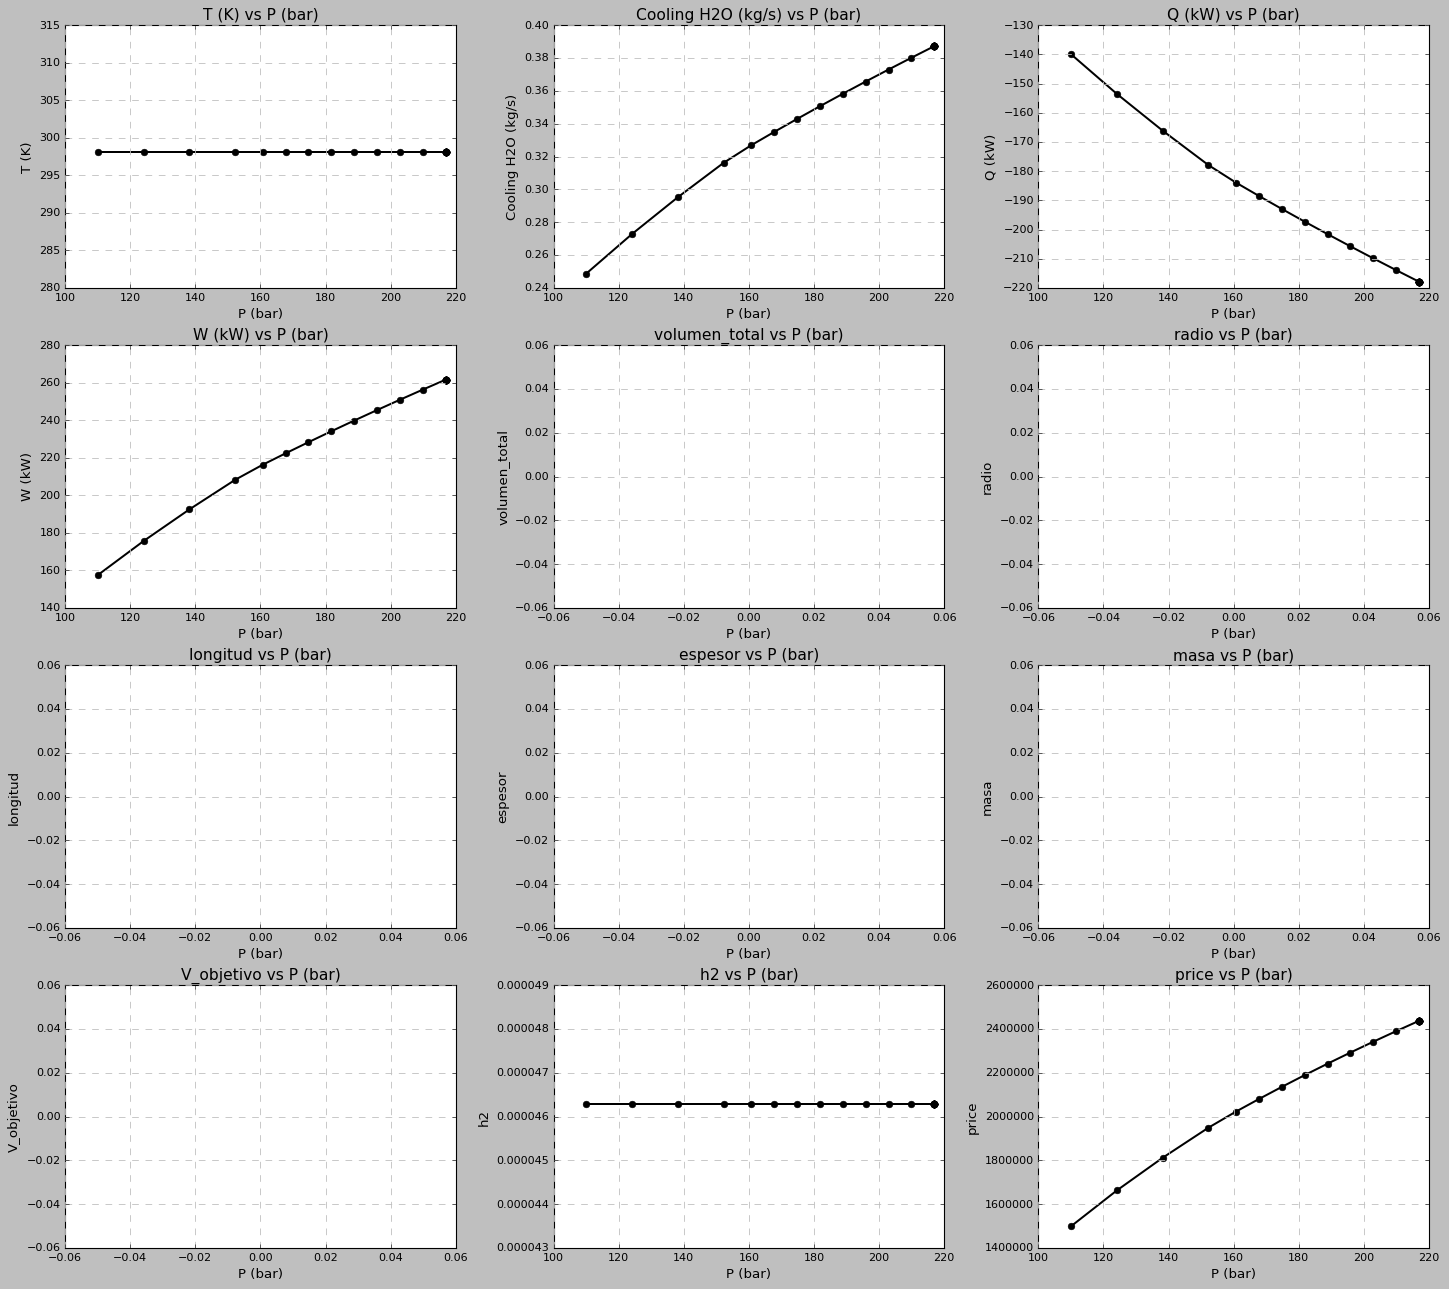

In [43]:
import matplotlib.pyplot as plt
import scienceplots  # Asegúrate de tener instalado: pip install SciencePlots
import math

# Desactivar el uso de LaTeX para evitar el error.
#plt.rcParams['text.usetex'] = False

# Utiliza una combinación de estilos populares para obtener un formato científico
#plt.style.use(['science'])#, 'ieee', 'std-colors'])

# Lista de variables a graficar versus "P (bar)"
variables_to_plot = [
    "T (K)",
    "Cooling H2O (kg/s)",
    "Q (kW)",
    "W (kW)",
    "volumen_total",
    "radio",
    "longitud",
    "espesor",
    "masa",
    "V_objetivo",
    "h2",
    "price"
]

# Se asume que df_resultados ya está definido y contiene la columna "P (bar)" y las demás variables
df_resultados_sorted = df_resultados.sort_values(by="P (bar)")

num_vars = len(variables_to_plot)
cols = 3
rows = math.ceil(num_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), constrained_layout=True)
axes = axes.flatten()

# Graficar cada variable versus "P (bar)"
for i, var in enumerate(variables_to_plot):
    ax = axes[i]
    ax.plot(
        df_resultados_sorted["P (bar)"],
        df_resultados_sorted[var],
        marker="o", linestyle="-", color="black"
    )
    ax.set_xlabel("P (bar)")
    ax.set_ylabel(var)
    ax.set_title(f"{var} vs P (bar)")
    ax.grid(True)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

# Eliminar axes vacíos en caso de que excedan el total de variables
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


In [44]:
df_resultados[df_resultados['price']==df_resultados['price'].min()]

,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),volumen_total,radio,longitud,espesor,masa,V_objetivo,h2,price,It. No.
0,298.15,110.0,0.248685,-139.907137,157.494764,None,None,None,None,None,None,0.000046,1.498861e+06,0


In [45]:
compis[0]

,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),T comp,Purchased Equipment Cost (USD)
0,No. 1,298.15,70.5,0.158417,-89.123348,104.349276,141.230366,"$250,029.51"
1,No. 2,298.15,110.0,0.090268,-50.783789,53.145488,84.447281,"$129,428.92"
2,Total,298.15,110.0,0.248685,-139.907137,157.494764,225.677647,"$379,458.43"


In [46]:
k=compis[df_resultados['It. No.'][18]]
k['Cooling H2O (kg/d)']=(k['Cooling H2O (kg/s)']*86400)/1e3
k

,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),T comp,Purchased Equipment Cost (USD),Cooling H2O (kg/d)
0,No. 1,298.15,93,0.217084,-122.128912,148.511128,189.958888,"$347,169.35",18.756095
1,No. 2,298.15,217,0.170214,-95.760435,113.222051,151.036844,"$270,011.95",14.706525
2,Total,298.15,217,0.387299,-217.889347,261.733179,340.995731,"$617,181.31",33.462620


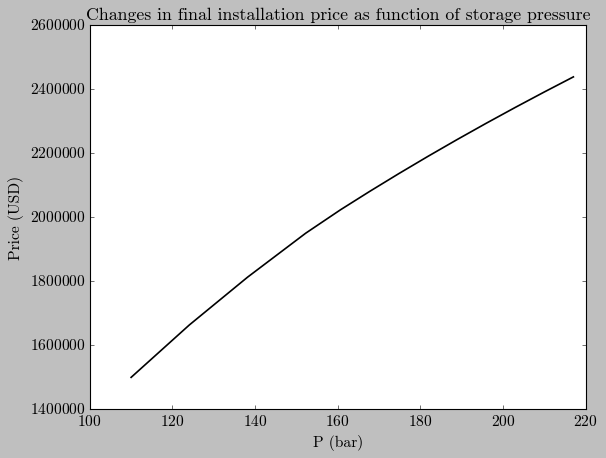

In [47]:
import matplotlib.pyplot as plt
#import scienceplots  # Asegúrate de tener instalado: pip install SciencePlots

# Opcional: activar un estilo popular (en este ejemplo usamos 'no-latex')
plt.style.use(['no-latex'])

# Se asume que df_resultados ya está definido y contiene las columnas "P (bar)" y "price"
df_resultados_sorted = df_resultados.sort_values(by="P (bar)")

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar 'price' en función de 'P (bar)'
ax.plot(df_resultados_sorted["P (bar)"], df_resultados_sorted["price"],
        linestyle="-", color="black",lw=1.5)

# Personalizar etiquetas y título
ax.set_xlabel("P (bar)", fontsize=14)
ax.set_ylabel("Price (USD)", fontsize=14)
ax.set_title("Changes in final installation price as function of storage pressure", fontsize=16)

# Activar la grilla y ajustar los ticks para un formato profesional

ax.tick_params(axis="both", which="major", labelsize=14, direction="in", top=True, right=True)
ax.tick_params(axis="both", which="minor", labelsize=12, direction="in", top=True, right=True)

# Forzar notación científica (esto hará que se muestre la notación ×10^...)
ax.ticklabel_format(axis="both", style="sci")

# Aumentar el tamaño de la fuente de la notación científica (offset text)
ax.xaxis.get_offset_text().set_fontsize(14)
ax.yaxis.get_offset_text().set_fontsize(14)

plt.show()


In [48]:
import matplotlib.pyplot as plt

# Imprime todos los estilos disponibles en Matplotlib
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'bright', 'cjk-jp-font', 'cjk-kr-font', 'cjk-sc-font', 'cjk-tc-font', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'grid', 'high-contrast', 'high-vis', 'ieee', 'latex-sans', 'light', 'muted', 'nature', 'no-latex', 'notebook', 'petroff10', 'pgf', 'retro', 'russian-font', 'sans', 'scatter', 'science', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'std-colors', 'tableau-colorblind10', 'turkish-font', 'vibrant']


Parámetros ajustados:
a = 67969.97729859322
n = 0.6655886149771763


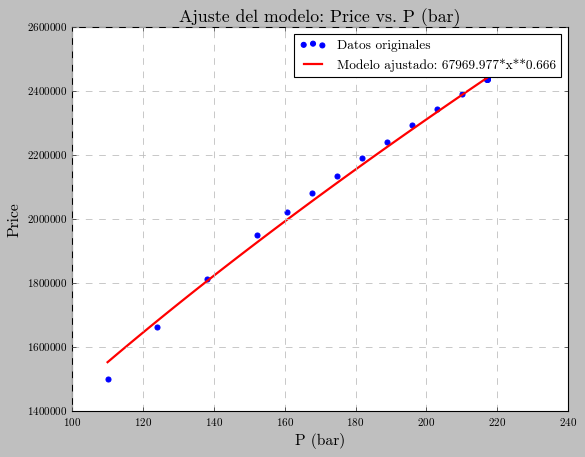

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Se asume que df_resultados ya está definido y contiene las columnas:
# 'P (bar)' -> variable independiente (x)
# 'price'   -> variable dependiente (y)
#
# Si deseas probar con datos simulados, puedes descomentar el siguiente bloque:
# df_resultados = pd.DataFrame({
#     "P (bar)": np.linspace(10, 100, 20),
#     "price": 2.5 * np.linspace(10, 100, 20)**1.2 + np.random.normal(0, 20, 20)
# })

# Extraer los datos
x = df_resultados['P (bar)'].values
y = df_resultados['price'].values

# Definir el modelo: f(x) = a * x^n
def model_func(x, a, n):
    return a * x**n

# Estimar valores iniciales para los parámetros (p0) es muy importante en la optimización no lineal
p0 = [1.0, 1.0]  # a = 1, n = 1, por ejemplo

# Ajuste del modelo usando curve_fit
# Usamos el método 'trf' para que se puedan pasar parámetros de tolerancia (xtol) y max_nfev
popt, pcov = curve_fit(
    model_func, 
    x, 
    y, 
    p0=p0, 
    method='trf', 
    xtol=1e-3,         # Tolerancia en los cambios en la solución 
    max_nfev=10000      # Número máximo de evaluaciones de la función
)

# Los parámetros optimizados se almacenan en popt
a_fit, n_fit = popt

print("Parámetros ajustados:")
print("a =", a_fit)
print("n =", n_fit)

# Crear puntos para graficar el modelo ajustado en el rango de los datos
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = model_func(x_fit, a_fit, n_fit)

# Graficar los datos originales y la curva ajustada
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Datos originales', color='blue')
plt.plot(x_fit, y_fit, label=f'Modelo ajustado: {a_fit:.3f}*x**{n_fit:.3f}', color='red', linewidth=2)
plt.xlabel("P (bar)", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.title("Ajuste del modelo: Price vs. P (bar)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Coeficientes ajustados:
a = -24.917267779595413
b = 16855.940792726928
c = -46904.79868703933


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


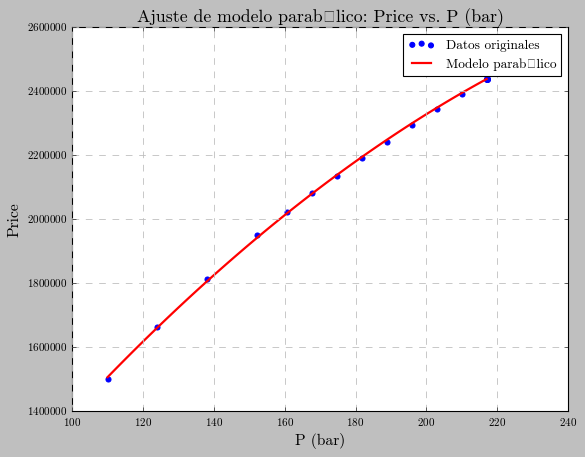

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que df_resultados ya está definido y contiene las columnas:
# 'P (bar)' para la presión y 'price' para el costo.
# Ejemplo de datos simulados (comenta o elimina estas líneas al trabajar con tus datos reales)
# df_resultados = pd.DataFrame({
#     "P (bar)": np.linspace(10, 100, 20),
#     "price": 0.05 * np.linspace(10, 100, 20)**2 - 2 * np.linspace(10, 100, 20) + 200 + np.random.normal(0, 20, 20)
# })

# Extraer datos de las columnas de interés
x = df_resultados['P (bar)'].values
y = df_resultados['price'].values

# Ajuste de un polinomio de grado 2 (parábola) a los datos
coeffs = np.polyfit(x, y, 2)  # coeffs = [a, b, c]
fitted_poly = np.poly1d(coeffs)

print("Coeficientes ajustados:")
print("a =", coeffs[0])
print("b =", coeffs[1])
print("c =", coeffs[2])

# Crear puntos para graficar la función ajustada
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = fitted_poly(x_fit)

# Graficar los datos originales y la curva ajustada
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Datos originales', color='blue')
plt.plot(x_fit, y_fit, label='Modelo parabólico', color='red', linewidth=2)
plt.xlabel("P (bar)", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.title("Ajuste de modelo parabólico: Price vs. P (bar)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [51]:
stages,temperature,Qk,Wk,waterr,price=[],[],[],[],[],[]
for i in range(len(Pes)):
    P=Pes[i]
    Po=31
    P_diff=P-Po
    P1=Po
    P2=P
    N_etapas=np.ceil((np.log(P2)/np.log(P1))/np.log(2))
    stages.append(N_etapas)
    P_etapa=P_diff/N_etapas
    Po=Po
    Pf=P
    P_acum=[Po]
    Temps=[25+273.15]
    Tref=Tref
    m=m
    eta=0.75
    Qs,Ts,m_H2O,comp,power,Ps=[],[],[],[],[],[]
    for i in range(int(N_etapas)):
        P1=sum(P_acum)
        print(P1)
        P_acum.append(P_etapa)
        P2=sum(P_acum)
        #Ti=(sum(P_acum)*V2*2)/(m*Z*8.314)
        #print('T',Ti)
        # Valor inicial para la incógnita x (en este caso, es un vector de una dimensión)
        x0 = [1.0]
        sol = root(trabajo_reversible_IT, x0=500, args=(m, P1, P2, eta,298.15), method='hybr')
        if sol.success:
            print(sol.message)
        else:
            print(sol.message)

        resultado = trabajo_reversible(m, P1, P2, eta, sol.x[0]-273.15,298.15)
        print(f"W: {resultado:.20f} kW")
        # Se utiliza scipy.optimize.root con método 'hybr'
        solucion = root(balance, x0, args=(sol.x[0],Tref, m), method='hybr')

        if solucion.success:
            x_encontrado = solucion.x[0]
            print(f"Solución encontrada: x = {x_encontrado:.6f}")
            Temps.append(25+273.15)
            Qs.append(float(-e))
            Ts.append((25+273.15))
            m_H2O.append(float(x_encontrado))
            comp.append('No. '+str(i+1))
            CP=19.67099783 + 0.069681519*T - 0.000200098*T**2 + 2.89493E-07*T**3 - 2.22475E-10*T**4 + 8.81466E-14*T**5 - 1.42043E-17*T**6
            CP=CP/2*1000
            power.append(resultado*1e3)
            Ps.append(P2)
        else:
            print("No se encontró solución:", solucion.message)
    # Crear un DataFrame con los datos
    data = {
        "Compressor": comp,
        "T (K)": Ts,
        "P (bar)": Ps,  # Convertir de Pa a bar
        "Cooling H2O (kg/s)": m_H2O,
        "Q (kW)": np.array(Qs),
        #"Q (kW) Aspen":np.array([-1645.66707374,-775.158866276,-514.144266522]),
        "W (kW)": np.array(power)
        #"W (kW) Aspen":np.array([2211.5522, 1052.84936, 706.504967])
        
    }

    df_compresores = pd.DataFrame(data)

    #df_compresores['Error %']=abs(((df_compresores['Q (kW) Aspen']-df_compresores['Q (kW) Python'])/df_compresores['Q (kW) Aspen']*100 + (df_compresores['W (kW) Aspen']-df_compresores['W (kW) Python'])/df_compresores['W (kW) Aspen']*100)/2)
    df_compresores.loc[df_compresores.shape[0]] = ["Total", Temps[-1], Ps[-1], sum(df_compresores['Cooling H2O (kg/s)']), sum(df_compresores['Q (kW)']), sum(df_compresores['W (kW)'])]
    calculator = PriceCalculator(df_compresores,N_etapas,CS)
    
    
    temperature.append(df_compresores.loc[df_compresores.shape[0]-1]['T (K)'])
    Qk.append(df_compresores.loc[df_compresores.shape[0]-1]['Q (kW)'])
    Wk.append(df_compresores.loc[df_compresores.shape[0]-1]['W (kW)'])
    waterr.append(df_compresores.loc[df_compresores.shape[0]-1]['Cooling H2O (kg/s)'])
    resultadot = calcular_dimension_tanque(P=df_compresores.loc[df_compresores.shape[0]-1]['P (bar)'], m=10000, crit=crit, tipo='hemi', rho_tank=4500)
    
    calculator1 = TankCostCalculator("Type I", resultadot['masa']*1e3)
    price.append(calculator.final+calculator1.final)
    

31
kW 1867.2835333955588
kW 1867.2835333955588
kW 1867.2835333955588
kW 1867.2835483360004
kW 1692.125003213775
kW 1690.4741173340667
kW 1690.4582729397364
kW 1690.4582714369349
The solution converged.
W: 0.10434927601462562485 kW
Solución encontrada: x = 0.158417
70.5
kW 1024.654754246111
kW 1024.654754246111
kW 1024.654754246111
kW 1024.654762370594
kW 862.9168037527157
kW 860.9828037583148
kW 860.9569083348937
kW 860.9569032420858
kW 860.9569032420729
The solution converged.
W: 0.05314548785444894036 kW
Solución encontrada: x = 0.090268
Volumen calculado del tanque: 1830.77 m³
Radio del tanque: 5.59 m
Longitud del tanque: 22.37 m
Espesor del tanque: 447.15 mm
Masa del tanque: 7443.47 ton
31
kW 1574.1256794339677
kW 1574.1256794339677
kW 1574.1256794339677
kW 1574.1256920455478
kW 1389.2961583083168
kW 1387.3212051758812
kW 1387.299170838977
kW 1387.2991679512647
The solution converged.
W: 0.08563575110810273117 kW
Solución encontrada: x = 0.133522
62.027210884353735
kW 930.190343655

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 1200.935329764297
kW 1200.935329764297
kW 1200.935329764297
kW 1200.935339182137
kW 1029.2387914412122
kW 1027.2432859383273
kW 1027.217994857182
kW 1027.2179904542832
kW 1027.2179904542731
The solution converged.
W: 0.06340851792927611197 kW
Solución encontrada: x = 0.103935
158.7687074829932
kW 807.9453286106464
kW 807.9453286106464
kW 807.9453286106464
kW 807.9453348324067
kW 671.9512040921936
kW 670.3325314724954
kW 670.3102466940165
kW 670.3102419937599
kW 670.3102419937461
The solution converged.
W: 0.04137717543171271634 kW
Solución encontrada: x = 0.074594
Volumen calculado del tanque: 856.48 m³
Radio del tanque: 4.34 m
Longitud del tanque: 17.36 m
Espesor del tanque: 702.61 mm
Masa del tanque: 4807.28 ton
31
kW 2664.7883548407453
kW 2664.7883548407453
kW 2664.7883548407453
kW 2664.788376057848
kW 2596.2021089721607
kW 2595.973032048265
kW 2595.9722718450334
kW 2595.9722718366907
The solution converged.
W: 0.16024520196522781812 kW
Solución encontrada: x = 0.232647
99.578231

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 595.24 m³
Radio del tanque: 3.84 m
Longitud del tanque: 15.38 m
Espesor del tanque: 976.6 mm
Masa del tanque: 4488.69 ton
31
kW 3496.899970397783
kW 3496.899970397783
kW 3496.899970397783
kW 3496.899998019575
kW 3677.716847840353
kW 3676.144938175081
kW 3676.159051921286
kW 3676.159053090355
The solution converged.
W: 0.22692339833891081446 kW
Solución encontrada: x = 0.320744
141.82312925170066
kW 1381.7336986314535
kW 1381.7336986314535
kW 1381.7336986314535
kW 1381.7337092105035
kW 1207.7875610834215
kW 1205.8870988063875
kW 1205.865059840467
kW 1205.8650566676338
The solution converged.
W: 0.07443611460911318811 kW
Solución encontrada: x = 0.118616
252.64625850340133
kW 908.847539528864
kW 908.847539528864
kW 908.847539528864
kW 908.8475462455483
kW 769.0610450972405
kW 767.4736852565102
kW 767.453292950228
kW 767.453289209107
kW 767.453289209098
The solution converged.
W: 0.04737365982772209078 kW
Solución encontrada: x = 0.082581
Volumen calculado de

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 4125.936530750851
kW 4125.936530750851
kW 4125.936530750851
kW 4125.93656305702
kW 4599.437399867278
kW 4588.298547670402
kW 4588.5861303660495
kW 4588.586337617883
kW 4588.586337613941
The solution converged.
W: 0.28324607022308273541 kW
Solución encontrada: x = 0.394459
184.06802721088434
kW 1482.6950875042057
kW 1482.6950875042057
kW 1482.6950875042057
kW 1482.6950985910014
kW 1311.9334432298392
kW 1310.174938222413
kW 1310.1560240457509
kW 1310.1560217177384
The solution converged.
W: 0.08087382850109496590 kW
Solución encontrada: x = 0.127185
337.1360544217687
kW 974.6230302494565
kW 974.6230302494565
kW 974.6230302494565
kW 974.623037173135
kW 835.5582722128553
kW 834.057466403103
kW 834.0394247618711
kW 834.0394218607222
kW 834.0394218607166
The solution converged.
W: 0.05148391492967386435 kW
Solución encontrada: x = 0.088055
Volumen calculado del tanque: 460.72 m³
Radio del tanque: 3.53 m
Longitud del tanque: 14.12 m
Espesor del tanque: 1258.06 mm
Masa del tanque: 4573.25 t

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 1032.4337321229182
kW 1032.4337321229182
kW 1032.4337321229182
kW 1032.4337391676238
kW 895.5237410170008
kW 894.1227155306213
kW 894.1069629419941
kW 894.1069607230907
The solution converged.
W: 0.05519178769895621145 kW
Solución encontrada: x = 0.092993
Volumen calculado del tanque: 391.8 m³
Radio del tanque: 3.34 m
Longitud del tanque: 13.38 m
Espesor del tanque: 1500.06 mm
Masa del tanque: 4819.31 ton
31
kW 4689.684123573196
kW 4689.684123573196
kW 4689.684123573196
kW 4689.684159910394
kW 5507.640585600514
kW 5472.51555065909
kW 5474.275014365205
kW 5474.280039720587
kW 5474.280038972774
The solution converged.
W: 0.33791852092424529141 kW
Solución encontrada: x = 0.464992
231.00680272108843
kW 1569.1446802156818
kW 1569.1446802156818
kW 1569.1446802156818
kW 1569.1446916292405
kW 1403.7839734137042
kW 1402.1933607901353
kW 1402.1776091636043
kW 1402.1776075280056
The solution converged.
W: 0.08655417330419788724 kW
Solución encontrada: x = 0.134744
431.01360544217687
kW 1038.5

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 5074.24986124612
kW 5074.24986124612
kW 5074.24986124612
kW 5074.249900216882
kW 6173.428954710482
kW 6106.733243642547
kW 6111.62253719981
kW 6111.653629850403
kW 6111.653614523896
The solution converged.
W: 0.37726256879777131381 kW
Solución encontrada: x = 0.514854
268.5578231292517
kW 1628.7103297413037
kW 1628.7103297413037
kW 1628.7103297413037
kW 1628.710341322595
kW 1468.3190975027203
kW 1466.8599785158933
kW 1466.8464484437784
kW 1466.8464472158435
The solution converged.
W: 0.09054607698863227638 kW
Solución encontrada: x = 0.140056
506.1156462585034
kW 1086.6769555856067
kW 1086.6769555856067
kW 1086.6769555856067
kW 1086.676962708185
kW 952.6032814905857
kW 951.3023623682246
kW 951.2886666970888
kW 951.2886650039327
The solution converged.
W: 0.05872152253110696218 kW
Solución encontrada: x = 0.097694
Volumen calculado del tanque: 346.33 m³
Radio del tanque: 3.21 m
Longitud del tanque: 12.84 m
Espesor del tanque: 1735.36 mm
Masa del tanque: 5160.06 ton
31
kW 5119.1426133

/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated.

In [52]:
resultados=pd.DataFrame()
resultados['P (bar)']=Pes
resultados['Stages']=stages
resultados['Q (kW)']=Qk
resultados['W (kW)']=Wk
resultados['H2O (kg/s)']=waterr
resultados['Price (USD)']=price

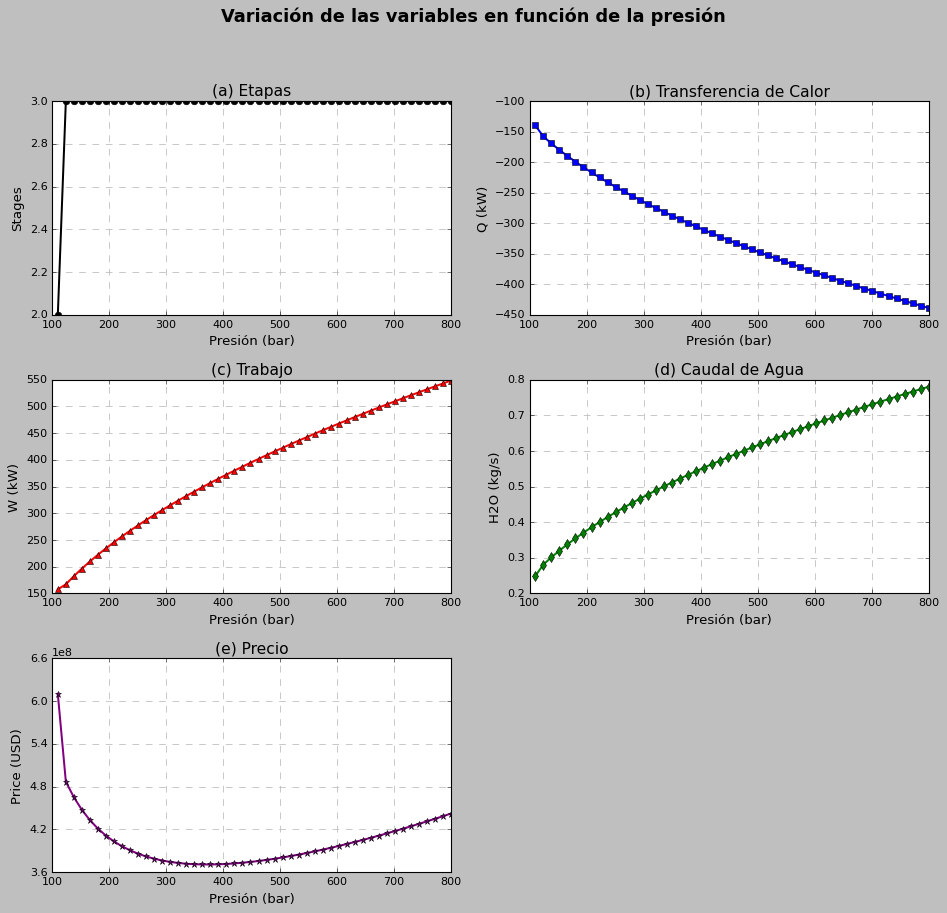

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker  # Para controlar la cantidad de ticks en el eje y

# Aplicamos el estilo clásico y actualizamos algunos parámetros estéticos
plt.style.use('classic')
plt.rcParams.update({
    'font.size': 12,             # Tamaño global de fuente
    'axes.labelsize': 12,        # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,        # Tamaño de los títulos de los ejes
    'xtick.labelsize': 10,       # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,       # Tamaño de las etiquetas del eje y
    'lines.linewidth': 1.8,      # Grosor de las líneas
    'lines.markersize': 6,       # Tamaño de los marcadores
    'grid.linestyle': '--',      # Estilo discontínuo para la rejilla
    'grid.linewidth': 0.75,      # Grosor de la rejilla
    'grid.color': '0.75',        # Color gris para la rejilla
})

# Se asume que las variables Pes, stages, Qk, Wk, waterr y price ya están definidas
resultados = pd.DataFrame({
    'P (bar)': Pes,
    'Stages': stages,
    'Q (kW)': Qk,
    'W (kW)': Wk,
    'H2O (kg/s)': waterr,
    'Price (USD)': price
})

# Configuración de la figura con 3 filas y 2 columnas (sin sharex para mostrar todos los valores en X)
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Variación de las variables en función de la presión', fontsize=16, fontweight='bold')

# Panel (a): Stages vs. Presión
axs[0, 0].plot(resultados['P (bar)'], resultados['Stages'],
               marker='o', linestyle='-', color='black')
axs[0, 0].set_ylabel('Stages')
axs[0, 0].set_title('(a) Etapas')
axs[0, 0].grid(True)
axs[0, 0].set_axisbelow(True)
axs[0, 0].set_xlabel('Presión (bar)')  # Se muestran los valores del eje de la presión

# Panel (b): Q (kW) vs. Presión
axs[0, 1].plot(resultados['P (bar)'], resultados['Q (kW)'],
               marker='s', linestyle='-', color='blue')
axs[0, 1].set_ylabel('Q (kW)')
axs[0, 1].set_title('(b) Transferencia de Calor')
axs[0, 1].grid(True)
axs[0, 1].set_axisbelow(True)
axs[0, 1].set_xlabel('Presión (bar)')

# Panel (c): W (kW) vs. Presión
axs[1, 0].plot(resultados['P (bar)'], resultados['W (kW)'],
               marker='^', linestyle='-', color='red')
axs[1, 0].set_ylabel('W (kW)')
axs[1, 0].set_title('(c) Trabajo')
axs[1, 0].grid(True)
axs[1, 0].set_axisbelow(True)
axs[1, 0].set_xlabel('Presión (bar)')

# Panel (d): H2O (kg/s) vs. Presión
axs[1, 1].plot(resultados['P (bar)'], resultados['H2O (kg/s)'],
               marker='d', linestyle='-', color='green')
axs[1, 1].set_ylabel('H2O (kg/s)')
axs[1, 1].set_title('(d) Caudal de Agua')
axs[1, 1].grid(True)
axs[1, 1].set_axisbelow(True)
axs[1, 1].set_xlabel('Presión (bar)')

# Panel (e): Price (USD) vs. Presión
axs[2, 0].plot(resultados['P (bar)'], resultados['Price (USD)'],
               marker='*', linestyle='-', color='purple')
axs[2, 0].set_ylabel('Price (USD)')
axs[2, 0].set_title('(e) Precio')
axs[2, 0].grid(True)
axs[2, 0].set_axisbelow(True)
axs[2, 0].set_xlabel('Presión (bar)')
# Reducir el número de ticks en el eje y a un máximo de 5 para el gráfico de Price
axs[2, 0].yaxis.set_major_locator(ticker.MaxNLocator(5))

# Ocultamos el panel vacío (última celda de la cuadrícula)
axs[2, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [54]:


P=172
Po=31
P_diff=P-Po
P1=Po
P2=P
N_etapas=np.ceil((np.log(P2)/np.log(P1))/np.log(2))
N_etapas
P_etapa=P_diff/N_etapas
Po=Po
Pf=P
P_acum=[Po]
Temps=[25+273.15]
Tref=Tref
m=m
eta=0.75
Qs,Ts,m_H2O,comp,power,Ps=[],[],[],[],[],[]
for i in range(int(N_etapas)):
    P1=sum(P_acum)
    print(P1)
    P_acum.append(P_etapa)
    P2=sum(P_acum)
    #Ti=(sum(P_acum)*V2*2)/(m*Z*8.314)
    #print('T',Ti)
    # Valor inicial para la incógnita x (en este caso, es un vector de una dimensión)
    x0 = [1.0]
    sol = root(trabajo_reversible_IT, x0=500, args=(m, P1, P2, eta,298.15), method='hybr')
    if sol.success:
        print(sol.message)
    else:
        print(sol.message)

    resultado = trabajo_reversible(m, P1, P2, eta, sol.x[0]-273.15,298.15)
    print(f"W: {resultado:.20f} kW")
    # Se utiliza scipy.optimize.root con método 'hybr'
    solucion = root(balance, x0, args=(sol.x[0],Tref, m), method='hybr')

    if solucion.success:
        x_encontrado = solucion.x[0]
        print(f"Solución encontrada: x = {x_encontrado:.6f}")
        Temps.append(25+273.15)
        Qs.append(float(-e))
        Ts.append((25+273.15))
        m_H2O.append(float(x_encontrado))
        comp.append('No. '+str(i+1))
        CP=19.67099783 + 0.069681519*T - 0.000200098*T**2 + 2.89493E-07*T**3 - 2.22475E-10*T**4 + 8.81466E-14*T**5 - 1.42043E-17*T**6
        CP=CP/2*1000
        power.append(resultado*1e3)
        Ps.append(P2)
    else:
        print("No se encontró solución:", solucion.message)
# Crear un DataFrame con los datos
data = {
	"Compressor": comp,
    "T (K)": Ts,
    "P (bar)": Ps,  # Convertir de Pa a bar
	"Cooling H2O (kg/s)": m_H2O,
	"Q (kW)": np.array(Qs),
    #"Q (kW) Aspen":np.array([-1645.66707374,-775.158866276,-514.144266522]),
    "W (kW)": np.array(power)
    #"W (kW) Aspen":np.array([2211.5522, 1052.84936, 706.504967])
    
}

df_compresores = pd.DataFrame(data)

#df_compresores['Error %']=abs(((df_compresores['Q (kW) Aspen']-df_compresores['Q (kW) Python'])/df_compresores['Q (kW) Aspen']*100 + (df_compresores['W (kW) Aspen']-df_compresores['W (kW) Python'])/df_compresores['W (kW) Aspen']*100)/2)
df_compresores.loc[df_compresores.shape[0]] = ["Total", Temps[-1], Ps[-1], sum(df_compresores['Cooling H2O (kg/s)']), sum(df_compresores['Q (kW)']), sum(df_compresores['W (kW)'])]
df_compresores


31
kW 2099.6081213396997
kW 2099.6081213396997
kW 2099.6081213396997
kW 2099.6081381186063
kW 1943.0449633545518
kW 1941.7791147680246
kW 1941.7688353379679
kW 1941.768834650278
The solution converged.
W: 0.11986227374384432476 kW
Solución encontrada: x = 0.179040
78.0
kW 1090.4662603714667
kW 1090.4662603714667
kW 1090.4662603714667
kW 1090.4662689896174
kW 924.2422462538713
kW 922.2707260516489
kW 922.2448043895358
kW 922.2447994955525
kW 922.24479949554
The solution converged.
W: 0.05692869132688518213 kW
Solución encontrada: x = 0.095306
125.0
kW 750.7507762999617
kW 750.7507762999617
kW 750.7507762999617
kW 750.7507821595873
kW 619.4312736720176
kW 617.8505447917091
kW 617.8282810823689
kW 617.828276158673
kW 617.8282761586584
The solution converged.
W: 0.03813754791102828834 kW
Solución encontrada: x = 0.070279


,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW)
0,No. 1,298.15,78.0,0.179040,-100.725834,119.862274
1,No. 2,298.15,125.0,0.095306,-53.618201,56.928691
2,No. 3,298.15,172.0,0.070279,-39.537813,38.137548
3,Total,298.15,172.0,0.344625,-193.881848,214.928513


In [55]:

calculator = PriceCalculator(df_compresores,N_etapas,CS)

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)


In [56]:
calculator.dataframe

,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),Purchased Equipment Cost (USD)
0,No. 1,298.15,78.0,0.179040,-100.725834,119.862274,"$379,742.01"
1,No. 2,298.15,125.0,0.095306,-53.618201,56.928691,"$184,893.71"
2,No. 3,298.15,172.0,0.070279,-39.537813,38.137548,"$122,987.33"
3,Total,298.15,172.0,0.344625,-193.881848,214.928513,"$687,623.05"


In [57]:
Tref

283.15

In [58]:
import numpy as np
import pandas as pd
from scipy.optimize import root, minimize

def normalize_price(price):
    """
    Convierte un valor de precio que puede venir formateado (por ejemplo, "$1,234.56")
    a un número tipo float.
    Si 'price' es un pandas.Series con un solo valor, se extrae ese valor.
    """
    # Si es una serie (con un solo valor), extraer el valor.
    if isinstance(price, pd.Series):
        price = price.iloc[0]
    
    # Si ya es numérico, lo retorna en forma float.
    if isinstance(price, (int, float)):
        return float(price)
    
    if isinstance(price, str):
        # Eliminar símbolos comunes: $, €, espacios y comas
        cleaned = price.replace("$", "").replace("€", "").replace(",", "").strip()
        try:
            return float(cleaned)
        except Exception as ex:
            raise ValueError("No se pudo normalizar el precio: '{}'".format(price))
    # De lo contrario, se intenta convertir a float
    return float(price)

def cost_function(P, m, Tref, T, CS, crit):
    """
    Función objetivo para minimizar; dada una presión P (en bar) calcula el costo total,
    el cual es la suma de:
      - El costo de compresión obtenido con PriceCalculator.
      - El costo del tanque obtenido con TankCostCalculator.
    
    Se normalizan los precios para asegurar que sean float antes de realizar la suma.

    Parámetros:
      - P   : Presión final (en bar). Es la variable independiente a optimizar.
      - m   : Parámetro relacionado a la masa o cantidad a comprimir.
      - Tref: Temperatura de referencia (en Kelvin).
      - T   : Temperatura usada en algunos cálculos (ej. en la ecuación de Cp).
      - CS  : Constante o parámetro requerido por PriceCalculator.
      - crit: Diccionario con las propiedades críticas (keys: 'Tc', 'Pc', 'PM', 'w').
    
    Devuelve:
      total_cost: Suma de los costos (float) de compresión y de tanque.
    """

    # Fijamos la presión de entrada (Po) a 31 bar.
    Po = 31  
    P=P[0]
    if P <= Po:
        # Penalizar fuertemente si la presión final no supera la de entrada.
        return 1e12

    P_diff = P - Po
    P1 = Po
    P2 = P
    # Estimación del número de etapas. Se redondea hacia arriba.
    N_etapas = np.ceil((np.log(P2) / np.log(P1)) / np.log(2))
    # Incremento de presión por etapa:
    P_etapa = P_diff / N_etapas

    # Variables iniciales para las etapas
    P_acum = [Po]            # Acumulador de presión
    Temps = [25 + 273.15]    # Temperatura en Kelvin (25°C + 273.15)
    eta = 0.75               # Eficiencia
    # Inicializar listas para los resultados de cada etapa
    Qs, Ts, m_H2O, comp, power, Ps_list = [], [], [], [], [], []
    
    # Bucle sobre las etapas de compresión:
    for j in range(int(N_etapas)):
        # La presión de entrada actual es la suma de los incrementos acumulados.
        P1_current = sum(P_acum)
        # Agregar la presión de la etapa y actualizar la presión de salida.
        P_acum.append(P_etapa)
        P2_current = sum(P_acum)
        
        # Resolver la ecuación de trabajo reversible (usando una función externa)
        sol = root(trabajo_reversible_IT, x0=500, args=(m, P1_current, P2_current, eta, 298.15), method='hybr')
        if not sol.success:
            return 1e12  # Penalización si no se converge

        # Calcular el trabajo (en kW) usando la función trabajo_reversible.
        # Se utiliza sol.x[0] - 273.15 para convertir de Kelvin a °C.
        resultado = trabajo_reversible(m, P1_current, P2_current, eta, sol.x[0] - 273.15, 298.15)
        
        # Resolver la ecuación de balance (por ejemplo, para obtener el caudal de enfriamiento),
        # usando root con un valor inicial.
        x0_vec = [1.0]
        solucion = root(balance, x0_vec, args=(sol.x[0], Tref, m), method='hybr')
        if not solucion.success:
            return 1e12
        x_encontrado = solucion.x[0]
        
        # Se asume un valor placeholder para "e" (ya que no está definido, se utiliza 0)
        e_value = 0  
        
        # Acumulación de datos para la etapa.
        Temps.append(25 + 273.15)
        Qs.append(float(-e_value))  # Aquí se debe introducir el valor correcto para Q.
        Ts.append(25 + 273.15)
        m_H2O.append(float(x_encontrado))
        comp.append('No. ' + str(j + 1))
        # Se calcula CP con una expresión polinómica (ejemplo, sin utilizarlo directamente)
        CP = (19.67099783 
              + 0.069681519 * T 
              - 0.000200098 * T**2 
              + 2.89493E-07 * T**3 
              - 2.22475E-10 * T**4 
              + 8.81466E-14 * T**5 
              - 1.42043E-17 * T**6)
        CP = CP / 2 * 1000
        
        power.append(resultado * 1e3)  # Convertir a Watts, por ejemplo.
        Ps_list.append(P2_current)
    
    # Armado del DataFrame con información de cada etapa.
    data = {
        "Compressor": comp,
        "T (K)": Ts,
        "P (bar)": Ps_list,  # Se trabaja con P en bar
        "Cooling H2O (kg/s)": m_H2O,
        "Q (kW)": np.array(Qs),
        "W (kW)": np.array(power)
    }
    df_compresores = pd.DataFrame(data)
    # Agregar una fila "Total" que resume los valores.
    total_row = ["Total",
                 Temps[-1],
                 Ps_list[-1],
                 df_compresores["Cooling H2O (kg/s)"].sum(),
                 df_compresores["Q (kW)"].sum(),
                 df_compresores["W (kW)"].sum()]
    df_compresores.loc[df_compresores.shape[0]] = total_row

    # --- Cálculo de costos ---
    # Se obtiene el costo del proceso de compresión.
    calculator = PriceCalculator(df_compresores, N_etapas, CS)
    cost_compression = normalize_price(calculator.final)

    # Se dimensiona el tanque utilizando la función calcular_dimension_tanque.
    resultadot = calcular_dimension_tanque(
        P=sum(Ps_list),
        m=10000,
        crit=crit,
        tipo='hemi',
        rho_tank=4500
    )
    # Se calcula el costo del tanque.
    calculator1 = TankCostCalculator("Type I", resultadot["masa"] * 1e3)
    cost_tank = normalize_price(calculator1.extras_df["Final Cost (USD)"])

    # Sumar ambos costos para obtener el costo total.
    total_cost = cost_compression + cost_tank
    print
    print('TOTAL:',total_cost)
    return total_cost

# --- Ejemplo de optimización usando scipy.minimize ---
if __name__ == '__main__':
    # Parámetros o variables del proceso (se deben definir según tu aplicación)
    m = 4/86400           # Ejemplo: masa o caudal relacionado
    Tref = Tref      # Temperatura de referencia en Kelvin
    T = 298.15         # Temperatura usada para ciertos cálculos (como CP)
    CS = "Carbon Steel"           # Constante para PriceCalculator (ejemplo)
    crit = crit
    
    # Definir límites para la presión óptima (en bar). Po es 31 en el código, así que se debe estar por encima.
    P_min = 50  
    P_max = 1000
    x0 = [900]  # Valor inicial en bar
    
    # Ejecutar la optimización
    res = minimize(cost_function, x0, args=(m, Tref, T, CS, crit),
                   bounds=[(P_min, P_max)])
    
    if res.success:
        print("Presión óptima encontrada (bar):", res.x[0])
        print("Costo total mínimo:", res.fun)
    else:
        print("La optimización falló:", res.message)


kW 5541.063399431749
kW 5541.063399431749
kW 5541.063399431749
kW 5541.0634414469505
kW 7032.575719247068
kW 6900.452524637113
kW 6914.935346060866
kW 6915.153880983119
kW 6915.153488377773
kW 6915.153488388297
kW 1703.815957234465
kW 1703.815957234465
kW 1703.815957234465
kW 1703.8159689704516
kW 1550.800507761304
kW 1549.5135785306297
kW 1549.5026795756426
kW 1549.5026787538607
kW 1151.1566151930156
kW 1151.1566151930156
kW 1151.1566151930156
kW 1151.1566223789655
kW 1021.0558684450076
kW 1019.8721568857829
kW 1019.8606396126753
kW 1019.8606383957296
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.15 ton
TOTAL: 8250604482.854986
kW 5541.063399459629
kW 5541.063399459629
kW 5541.063399459629
kW 5541.063441474828
kW 7032.575662968159
kW 6900.4525320083
kW 6914.935346325855
kW 6915.153881031335
kW 6915.153488426571
kW 6915.1534884370985
kW 1703.8159572390753
kW 1703.8159572390753
kW 170

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 1704.3741551711246
kW 1551.4172173924671
kW 1550.131570144989
kW 1550.1206896606407
kW 1550.1206888414258
kW 1151.6492984269307
kW 1151.6492984269307
kW 1151.6492984269307
kW 1151.649305613276
kW 1021.5806029126599
kW 1020.3977651676512
kW 1020.3862632947585
kW 1020.3862620808967
Volumen calculado del tanque: 2119.24 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7825.31 mm
Masa del tanque: 101174.26 ton
TOTAL: 8273495842.898804
kW 5544.436538310267
kW 5544.436538310267
kW 5544.436538310267
kW 5544.436580346802
kW 7038.9863161842895
kW 6906.248461088251
kW 6920.837657710064
kW 6921.059092568458
kW 6921.058691250958
kW 6921.058691261874
kW 1704.3741434388003
kW 1704.3741434388003
kW 1704.3741434388003
kW 1704.3741551757341
kW 1551.4172192204558
kW 1550.1315701653841
kW 1550.1206896657482
kW 1550.1206888465304
kW 1151.649298431
kW 1151.649298431
kW 1151.649298431
kW 1151.6493056173451
kW 1021.580603215299
kW 1020.3977651748601
kW 1020.3862632991006
kW 102

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7813.0 mm
Masa del tanque: 100894.21 ton
TOTAL: 8250609431.106407
kW 5541.0641296172325
kW 5541.0641296172325
kW 5541.0641296172325
kW 5541.064171632434
kW 7032.577011282047
kW 6900.453791625318
kW 6914.936623972385
kW 6915.155159151562
kW 6915.154766545342
kW 6915.154766555865
kW 1703.8160780381359
kW 1703.8160780381359
kW 1703.8160780381359
kW 1703.8160897741238
kW 1550.8006393669477
kW 1549.5137122567726
kW 1549.5028133213843
kW 1549.5028124996068
kW 1151.1567218012362
kW 1151.1567218012362
kW 1151.1567218012362
kW 1151.1567289871864
kW 1021.055981800389
kW 1019.8722706144407
kW 1019.860753346456
kW 1019.8607521295129
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7813.0 mm
Masa del tanque: 100894.21 ton
TOTAL: 8250609430.96644
kW 5541.063475059581
kW 5541.063475059581
kW 5541.063475059581
kW 5541.06351

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 6915.1534885688225
kW 6915.153488579355
kW 1703.815957252521
kW 1703.815957252521
kW 1703.815957252521
kW 1703.8159689885088
kW 1550.8005059576906
kW 1549.5135785353136
kW 1549.5026795956314
kW 1549.5026787738516
kW 1151.1566152089501
kW 1151.1566152089501
kW 1151.1566152089501
kW 1151.156622394902
kW 1021.0558660749194
kW 1019.87215687982
kW 1019.8606396296701
kW 1019.8606384127304
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.15 ton
TOTAL: 8250604483.805118
kW 5541.063399439402
kW 5541.063399439402
kW 5541.063399439402
kW 5541.063441454605
kW 7032.575738036692
kW 6900.452522209452
kW 6914.935346002197
kW 6915.153880996709
kW 6915.153488391169
kW 6915.153488401702
kW 1703.8159572357306
kW 1703.8159572357306
kW 1703.8159572357306
kW 1703.8159689717208
kW 1550.800501927148
kW 1549.5135784830497
kW 1549.5026795770375
kW 1549.5026787552633
kW 1151.1566151941342
kW 1151.1566151941342


/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.15 ton
TOTAL: 8250604482.854986
kW 5541.063399459627
kW 5541.063399459627
kW 5541.063399459627
kW 5541.063441474829
kW 7032.575719296394
kW 6900.45252468548
kW 6914.935346109659
kW 6915.153881031921
kW 6915.153488426571
kW 6915.153488437095
kW 1703.8159572390762
kW 1703.8159572390762
kW 1703.8159572390762
kW 1703.8159689750646
kW 1550.8005048486311
kW 1549.5135785112436
kW 1549.5026795807446
kW 1549.502678758967
kW 1151.156615197086
kW 1151.156615197086
kW 1151.156615197086
kW 1151.1566223830355
kW 1021.0558690461154
kW 1019.8721568958656
kW 1019.8606396170183
kW 1019.8606384000725
Volumen calculado del tanque: 2117.63 m³
Radio del tanque: 5.87 m
Longitud del tanque: 23.48 m
Espesor del tanque: 7812.99 mm
Masa del tanque: 100894.15 ton
TOTAL: 8250604482.64502
kW 5541.063399431846
kW 5541.063399431846
kW 5541.063399431846
kW 5541.063441447

/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1702185921.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_23323/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 